# Hands-On NLP — Class 3

<span style="color:magenta">Group Names:</span>

* Ying Lai 22305391
* Yingjie Liu 22200660

## Outline

- Better vectors: Tf-idf

- Ngrams

- Text generation

In [1]:
import re
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.3.2
print("nltk's version:", nltk.__version__)          # 3.8.1
print("pandas's version:", pd.__version__)          # 2.1.4

sklearn's version: 1.4.0
nltk's version: 3.8.1
pandas's version: 2.1.4


[nltk_data] Downloading package punkt to /Users/yinglai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

## Getting the data

In [4]:
DATA = Path("../data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [5]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [6]:
all_df = pd.DataFrame.from_records(data, index=["id"])
all_df = all_df.drop("robotics.stackexchange_0000005103")
all_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0
...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5


---
Here the initialization of `all_df` is done and you can jump to your favorite classification
___

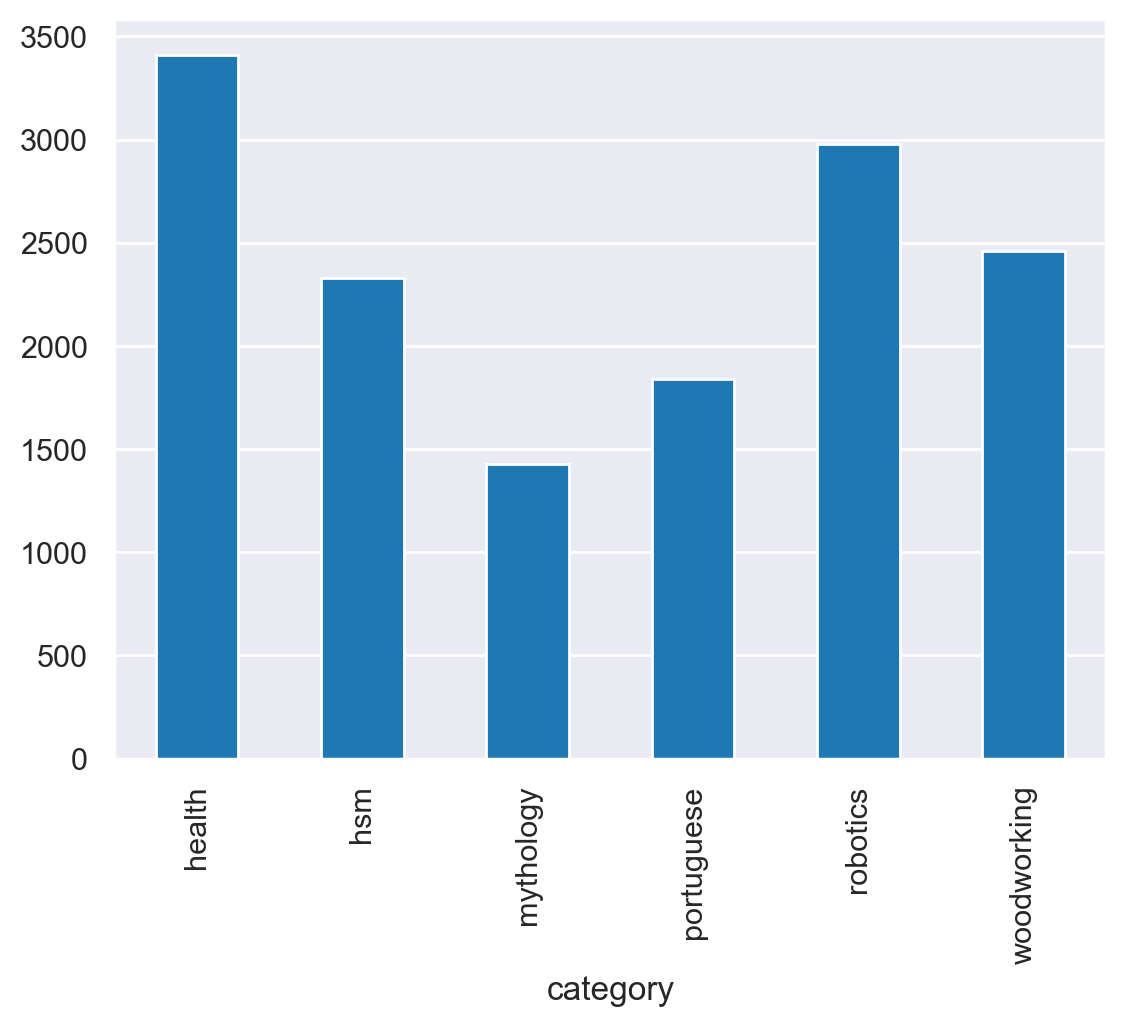

In [7]:
all_df.groupby("category").size().plot.bar()
plt.grid(axis="x")

## Vectorize

In [8]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()
print(xs.shape)
# . toarray takes an iterable and figures out what the smallest python array type can hold the values. 
# returns an array if all values can fit or a list if not.
print(vectorizer.get_feature_names_out())

cv_df = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
cv_df

(4, 9)
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


### TF-IDF

- The counting of words is not the ideal way to represent a document

- Instead of counting the number of occurences of a word, we could weight it by the number of documents it appears in

- Term Frequency - Inverse Document Frequency

#### From [Wikipedia](https://en.wikipedia.org/wiki/Tf-idf):

**Term frequency**

$$\operatorname{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}$$

**Inverse document frequency**

$$\operatorname{idf}(t, D) =  - \log \frac{|\{d \in D: t \in d\}|}{N} = 
    -\log \left({\frac {n_{t}}{N}}\right) $$

N: total number of documents in the corpus $N = {|D|}$

**Smoothed IDF:**

$$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {N}\right)+ 1$$

#### From [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting):

In `TfidfVectorizer`, the implementation is slightly different:

*   For the IDF:

    *   Unsmoothed version (`smooth_idf=False`), though a $+1$ is applied to avoid a value of 0 for the IDF:
    $$\operatorname{idf}(t, D) = -\log \left({\frac {n_{t}}{N}}\right) + 1$$

    *   Smoothed version (`smooth_idf=True`):
    $$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {1 + N}\right)+ 1$$

*   `TFIDF = tf(t, d) * idf(t, D)`

*   `tf(t, d)` is the **count** of the term `t` in the document `d`, not the **frequency** (**no division!**)

*   Then a global normalization is applied: `TFIDF = TFIDF / norm(TFIDF)`
    
    (instead of a normalization within `tf` only to obtain a frequency)

*   `norm` is the L2 norm by default, but can be changed to L1 or `None`.

#### 🚧 TODO: Count vs. Freq vectorizers

Compare the previous results of the `CountVectorizer` with the `TfidfVectorizer` on the same toy dataset.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf_idf = ...
tf_idf = TfidfVectorizer()
xs =  tf_idf.fit_transform(corpus).toarray()

tfidf_df = pd.DataFrame(xs, index=corpus, columns=tf_idf.get_feature_names_out())
tfidf_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841
This document is the second document.,0.0000,0.6876,0.0000,0.2811,0.0000,0.5386,0.2811,0.0000,0.2811
And this is the third one.,0.5118,0.0000,0.0000,0.2671,0.5118,0.0000,0.2671,0.5118,0.2671
Is this the first document?,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841


### Let's now classify the StackOverflow documents in their respective corpus label

*   The complete corpus: `all_df`

*   Let's use the different vectorizers for representation

In [10]:
ys = all_df.cat_id.values

In [11]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(all_df.text).toarray()

In [12]:
print("xs.shape =", xs.shape)
print("ys.shape =", ys.shape)

xs.shape = (14450, 5000)
ys.shape = (14450,)


In [13]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


#### 🚧 TODO: `CountVectorizer` vs. `TfidfVectorizer` classifiers

*   Limit to the 5000 most frequent words to reduce the dimensionality

    (the sparse matrix `toarray()` method crashes if no reduction of features is applied)

*   Use both to classify the data based on, e.g., the `MultinomialNB` classifier

*   Compare their results in terms of accuracy and show their `classification_report`

In [14]:
# Use both to classify the data based

# Used on CountVectorizer

# Import library
# Multinomial Naive bayes
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(train_xs,train_ys)
ys_pred = model.predict(test_xs)

# Compare their results in terms of accuracy
from sklearn import metrics
accuracy = metrics.accuracy_score(test_ys, ys_pred)
print(f'The accuracy is {accuracy:5f}')

# Show their classification_report
print(metrics.classification_report(test_ys, ys_pred))


The accuracy is 0.974164
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       420
           1       0.97      1.00      0.98       692
           2       0.98      0.97      0.98       935
           3       0.95      0.97      0.96       709
           4       0.98      0.98      0.98      1054
           5       1.00      0.93      0.96       525

    accuracy                           0.97      4335
   macro avg       0.97      0.97      0.97      4335
weighted avg       0.97      0.97      0.97      4335



In [15]:
# TfidfVectorizer

# Limit to the 5000 most frequent words
tfidf = TfidfVectorizer(max_features=5000)
xs_tf = tfidf.fit_transform(all_df['text'])

In [16]:
train_xs_tf, test_xs_tf, train_ys_tf, test_ys_tf = train_test_split(
    xs_tf, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs_tf.shape)
print(test_xs_tf.shape)

(10115, 5000)
(4335, 5000)


In [17]:
# Used on TfidfVectorizer

model = MultinomialNB()
model.fit(train_xs_tf,train_ys_tf)
ys_pred_tf = model.predict(test_xs_tf)

# Compare their results in terms of accuracy
from sklearn import metrics
accuracy = metrics.accuracy_score(test_ys_tf, ys_pred_tf)
print(f'The accuracy is {accuracy:5f}')

# Show their classification_report
print(metrics.classification_report(test_ys_tf, ys_pred_tf))

The accuracy is 0.974856
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       420
           1       0.97      1.00      0.98       692
           2       0.97      0.98      0.98       935
           3       0.95      0.97      0.96       709
           4       0.98      0.99      0.99      1054
           5       1.00      0.93      0.97       525

    accuracy                           0.97      4335
   macro avg       0.98      0.97      0.97      4335
weighted avg       0.98      0.97      0.97      4335



#### 🚧 TODO: `MultinomialNB` vs. `GaussianNB` classifiers

*   Use both to classify the data

*   Compare their results in terms of accuracy and show their `classification_report`

In [18]:
# Gaussian Naive bayes
from sklearn.naive_bayes import GaussianNB

In [19]:
# CountVectorizer
model = GaussianNB()
model.fit(train_xs,train_ys)
ys_pred = model.predict(test_xs)

# Compare their results in terms of accuracy
from sklearn import metrics
accuracy = metrics.accuracy_score(test_ys, ys_pred)
print(f'The accuracy is {accuracy:5f}')

# Show their classification_report
print(metrics.classification_report(test_ys, ys_pred))

The accuracy is 0.950404
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       420
           1       0.95      0.97      0.96       692
           2       0.97      0.95      0.96       935
           3       0.92      0.89      0.91       709
           4       0.96      0.96      0.96      1054
           5       0.98      0.98      0.98       525

    accuracy                           0.95      4335
   macro avg       0.95      0.95      0.95      4335
weighted avg       0.95      0.95      0.95      4335



In [20]:
# TfidfVectorizer
model = MultinomialNB()
model.fit(train_xs_tf,train_ys_tf)
ys_pred_tf = model.predict(test_xs_tf)

# Compare their results in terms of accuracy
from sklearn import metrics
accuracy = metrics.accuracy_score(test_ys_tf, ys_pred_tf)
print(f'The accuracy is {accuracy:5f}')

# Show their classification_report
print(metrics.classification_report(test_ys_tf, ys_pred_tf))

The accuracy is 0.974856
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       420
           1       0.97      1.00      0.98       692
           2       0.97      0.98      0.98       935
           3       0.95      0.97      0.96       709
           4       0.98      0.99      0.99      1054
           5       1.00      0.93      0.97       525

    accuracy                           0.97      4335
   macro avg       0.98      0.97      0.97      4335
weighted avg       0.98      0.97      0.97      4335



#### 🚧 TODO: Confusion matrix for the MultinomialNB classifier

- Verify in a confusion matrix that the precision of portuguese is 1.00 and its recall is about 0.93 with the `MultinomialNB` classifier on the Tfidf vectorizer

- Translate this result into a sentence

In [21]:
# MultinomialNB
# 首先确保所有的数据都是用multinpmialNB做出来的
model = MultinomialNB()
model.fit(train_xs_tf,train_ys_tf)
ys_pred_tf = model.predict(test_xs_tf)

In [22]:
#
# print('Precision: ' + str(precision_score(test_ys,pred_ys, average='weighted')))
# print(metrics.confusion_matrix)

#### 🚧 TODO: add the `stop_words="english"` option to the `tf_idf` vectorizer 

*   Compare the size of the `sparse_xs` for the 2 conditions (stop words included or not)

*   Retrain with the new vectorizer and the MultinomialNB classifier

*   Compare the results with the previous vectorizer

In [23]:
# With stop words
tf_idf_stop = TfidfVectorizer(stop_words="english")
sparse_xs = tf_idf_stop.fit_transform(all_df.text).toarray()

In [24]:
print(sparse_xs.shape)

(14450, 152763)


In [25]:
# Without stop words
tf_idf = TfidfVectorizer()
xs_try = tf_idf.fit_transform(all_df.text).toarray()
print(xs_try.shape)

(14450, 153076)


In [ ]:
# Retrain with the new vectorizer
train_xs_tf_stop, test_xs_tf_stop, train_ys_tf_stop, test_ys_tf_stop = train_test_split(
    sparse_xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs_tf_stop.shape)
print(test_xs_tf_stop.shape)

# the MultinomialNB classifier
model = MultinomialNB()
model.fit(train_xs_tf_stop,train_ys_tf_stop)
ys_pred_tf_stop = model.predict(test_xs_tf_stop)

In [ ]:
# Compare with the previous vectorizer
accuracy = metrics.accuracy_score(test_ys_tf_stop, ys_pred_tf_stop)
print(f'The accuracy is {accuracy:5f}')

# Show their classification_report
print(metrics.classification_report(test_ys_tf_stop, ys_pred_tf_stop))

#### 🚧 TODO: PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test) and plot them

*   Compare the plot with the previous vectorizer with, and without the `stop_words="english"` option

*   Explain the difference breafly

#### 🚧 TODO: Train on PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test), fitting the PCA only on the training set

*   Train the MultinomialNB and the GaussianNB classifiers on the PCA vectors

    Does it work with both classifiers? Explain breafly.

*   Compare the results with the vectorizer with, and without, the `stop_words="english"` option

*   Analyze the difference breafly

#### 🚧 TODO: PCA with more dimensions

*   Try to find the best number of dimensions for the PCA with [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

*   Use pipeline to combine the PCA and the classifier and other potential preprocessing steps

*   Boxplot accuracyies for different PCA dimension values using 

## N-grams features for text classification

*   We will use bigram in this section

In [ ]:
vectorizer_2g = CountVectorizer(
    analyzer="word", ngram_range=(2, 2), max_features=5000,
)
x2gs = vectorizer_2g.fit_transform(all_df.text).toarray()

In [ ]:
pd.DataFrame(vectorizer_2g.get_feature_names_out(), columns=["bigrams"])

In [ ]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    x2gs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

#### 🚧 TODO: Train classification models on n-grams

*   Train on the `CountVectorizer` with ngrams using the `MultinomialNB` classifier

*   Compare the results with the previous "raw" `CountVectorizer`

---
## Building an n-gram generator
___

### Let's build character trigrams first

In [ ]:
LINE = "This is cool!"
N = 3
[LINE[i : i + N] for i in range(len(LINE) - N + 1)]

In [ ]:
[tuple(LINE[i : i + N]) for i in range(len(LINE) - N + 1)]

In [ ]:
LINES = """This is cool!
This is amazing!
But why is this his fish?"""

re.split("\n+", LINES.lower())

In [ ]:
ngrams = collections.Counter()

for line in re.split("\n+", LINES.lower()):
    ngrams.update([line[i : i + N] for i in range(len(line) - N + 1)])

nc_df = pd.DataFrame.from_dict(
    ngrams, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)

nc_df.head(7)

### Back to our corpora

#### 🚧 TODO: Build an ngram generator for the `"woodworking"` corpus

*   Tokenize the corpus first with `nltk.word_tokenize`

*   Normalize the tokens by simply simply lowercasing them

*   Give the tokens frequency to the ngram generator

In [ ]:
wood_df = all_df[all_df.category == "woodworking"]
wood_df.head()

In [ ]:
wood_txt = wood_df.iloc[0].text
print(wood_txt[:333])

#### 🚧 TODO: Text generation with ngrams

*   Generate a text of words until a stop word is generated (`.`)

*   Assign a probability to each ngrams based on their frequency

*   Sample from the ngrams based on their probability

*   Try different starting words (use bigrams)

 *Note:* [`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is the recommended constructor for random number generation in NumPy.

### TODO (optional): Improve this algorithm

- Try to fix some possible issues, by handeling exceptions

- Improve the output spacing (no space before comma, etc.) and maybe handle the upper case

- Try on a different domain of our corpus

---